<h1 style="text-align: center;"><b>Sentiment Analysis of Poetry II </b></h1>
<h5 style="text-align: center;"><I>Identifying cluster themes in poetry using word embeddings and topic modeling </I></h5>


#### **Table of Contents**

1. **Executive Summary**
2. **Introduction**
<br>
2.1 *Recap*
<br>
2.2 *Current approach*
3. **Importing data and packages** 
4. **Preprocessing**
5. **Exploratory data analysis**
6. **NLP**
<br>
6.1 *Approach 1: Word embeddings and clustering*
<br>
6.2 *Approach 2: Topic Modeling with LDA*
<br>
6.3 *Approach 3: Topic Modeling with feature extraction*
<br>
7. **Conclusion**  
8. **Use of AI tools**
9. **Data Ethics**
10. **References**

--------------------

#### **1. Executive Summary**

This project an exploration into sentiment analysis of poetry text data. It is a continuation of a previous project that used TF-idf to vectorize the text data and then used K-means clustering to identify clusters of poems. The current project uses word embeddings and topic modeling to extract salient features of the data. Each approach used in this project builds in some way on the previous one, to see if the results can be improved.



--------------------------------

#### **2. Introduction**

2.1 *Recap*

Previously, I was working with text data from my own personal poetry collection. I preprocessed the data and vectorized it using TF-IDF. I then used K-Means clustering to identify the clusters and themes in my poetry. Through hyperparameter tuning, I found that that the optimal number of clusters was 3, with a silhouette score of 0.0659. At the end of the report, I explored the use of word embeddings, using the word2vec model and found an improved performance with a silhouette score of 0.12. This report is a further investigation on the use of word embeddings and topic modeling to identify clusters and themes in poetry.

My previous pipeline looked like this:

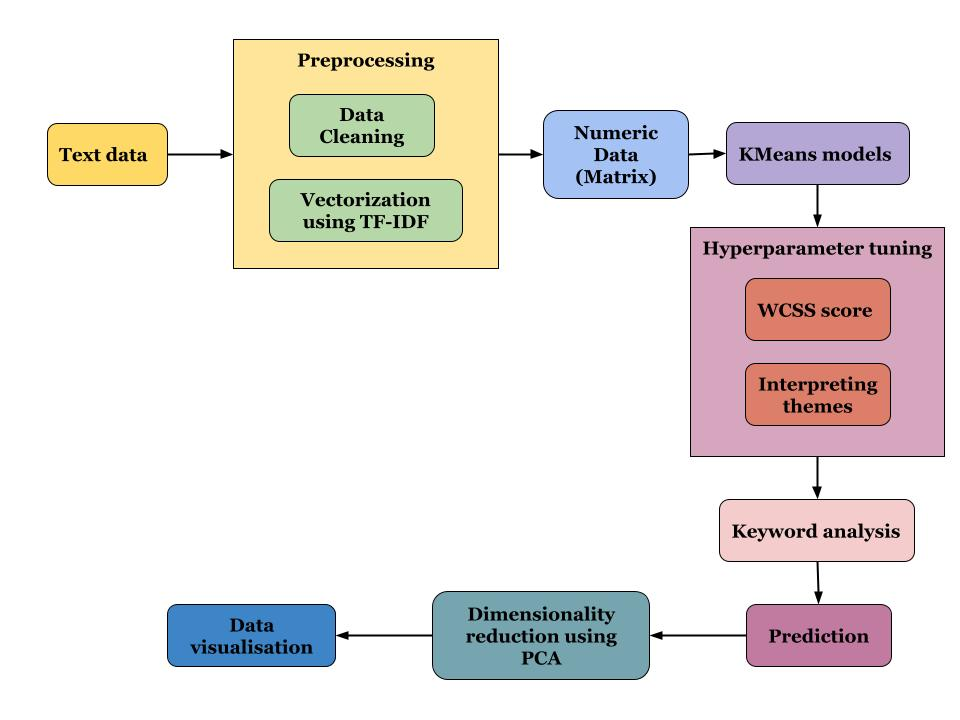

In [111]:
from IPython.display import Image
Image(filename='data pipeline.jpg', width=600)

2.2 *Current approach*

For my current approach, I will be using the same dataset but with a few different models that I will be comparing in terms of their algorithm, scalability, and performance. I will be using the following models:
1. Transfer Learning: Using a pre-trained word embedding model (ELMO) to process my data and then using K-Means clustering to identify the clusters and themes in my poetry.
2. Topic Modeling: Using Latent Dirichlet Allocation (LDA) to identify the clusters and themes in my poetry.
3. Topic Modeling with feature extraction: Using autoencoders to extract features from the word embeddings and then using LDA to identify 


------------------------------------------

#### **3. Importing data and packages**

**Note**

The packages used in this notebook have shown incompatibility at several points, therefore, I mention the versions of the packages I used in this notebook. If the code runs on the versions you have installed, you can skip this step, otherwise, apologies in advance for the inconvenience.
 

In [2]:
#!pip install pandas==1.5.3 --user
#!pip install tensorflow==2.4.3 --user
#!pip install tensorflow_hub==0.12.0
#!pip install keras==2.4.3
#!pip install numpy==1.20.3 --user

In [3]:
#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#importing sklearn libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation

#importing NLP libraries
import nltk
#nltk.download('punkt')
import re
import string
pd.set_option('display.max_colwidth', 100)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#importing deep learning libraries
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Model, Sequential
from keras.layers import Input, Dense


In [5]:
# importing the data
df = pd.read_csv('data.txt', sep='\t', header=None)
df = df.rename(columns = {0:'poetry'}) #renaming the column
df.head()

,poetry
0,Night skies and tales spun from candied sugar - you listened to an entire world I had built in m...
1,"And when I raged at the world, you took every punch without flinching for a single second. I scr..."
2,"We talked about the universe and the stars and the lines on our palms. If there was a forever, I..."
3,Is this what home feels like? Scarred palms and chipped nails. That’s what we were and yet we fi...
4,Starkissed lullabies of fallen heroes and ancient kings. you remind me of the single second as t...


------------------------------------------

#### **4. Preprocessing**

This code is the same as used in the previous assignment. 

In [6]:
stopwords.words('english')

def clean_data(text:str, remove_stopwords: bool = True) -> str:
    """
    Preprocesses a given string of text by removing special characters, multiple space characters, and optionally, stopwords.

    Args:
        text (str): A string of text to be preprocessed.
        remove_stopwords (bool, optional): A boolean value indicating whether or not to remove stopwords from the text. Defaults to True.

    Returns:
        str: The preprocessed string of text.

    Example:
        >>> preprocess("This is an example sentence! It includes special characters, such as @ and $.", True)
        'example sentence includes special characters'
    """
    #remove special characters
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text) 
    
    #remove multiple space characters
    text = re.sub("\s+"," ", text)

    #remove stopwords
    if remove_stopwords == True:
        #tokenizing
        tokens = word_tokenize(text)
        #check for stopwords
        tokens = [word for word in tokens if not word.lower() in stopwords.words("english")]
        text = " ".join(tokens)

    text = text.lower()
    return text

clean_data(df['poetry'][0], True)


'night skies tales spun candied sugar listened entire world built head laughed cue smiled position love never felt like breath fresh air friendship never tasted like freedom'

In [7]:
df['cleaned'] = df['poetry'].apply(lambda x: clean_data(x, remove_stopwords=True))
df.head()

,poetry,cleaned
0,Night skies and tales spun from candied sugar - you listened to an entire world I had built in m...,night skies tales spun candied sugar listened entire world built head laughed cue smiled positio...
1,"And when I raged at the world, you took every punch without flinching for a single second. I scr...",raged world took every punch without flinching single second screamed set everything fire stood ...
2,"We talked about the universe and the stars and the lines on our palms. If there was a forever, I...",talked universe stars lines palms forever wanted mine tales oceans skies ever written wanted wri...
3,Is this what home feels like? Scarred palms and chipped nails. That’s what we were and yet we fi...,home feels like scarred palms chipped nails yet fit hand mine coming back war must feel like con...
4,Starkissed lullabies of fallen heroes and ancient kings. you remind me of the single second as t...,starkissed lullabies fallen heroes ancient kings remind single second time bends sword hits mark...


------------------------------------------

#### **5. Exploratory data analysis**

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (3, 3)
stop_words = "english"

# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(df['cleaned'])
count.vocabulary_

#making an n-gram plot

sorted(count.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:10]

    

[('zero errors measurements', 1235),
 ('young soul sign', 1234),
 ('yearn silence lake', 1233),
 ('yawned horizon seen', 1232),
 ('written wanted write', 1231),
 ('wrapped embrace filled', 1230),
 ('wounds brush past', 1229),
 ('wound question instead', 1228),
 ('worlds cruel mean', 1227),
 ('world took punch', 1226)]

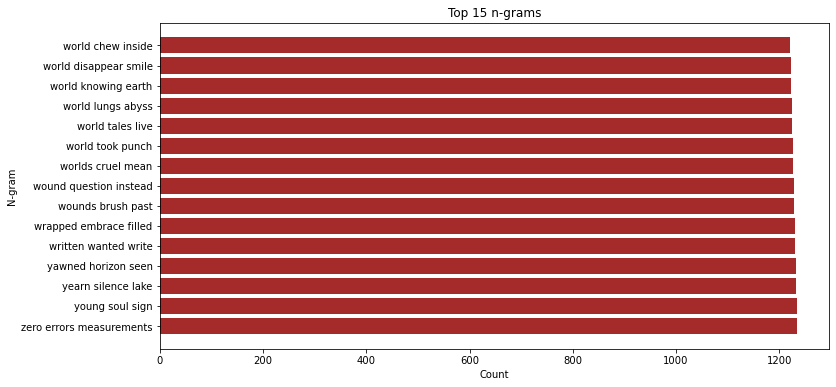

In [10]:
#making an n-gram plot

def plot_ngrams(count_vectorizer, n=3):
    """
    Plots the top n n-grams.

    Args:
        count_vectorizer (CountVectorizer): A CountVectorizer object.
        n (int, optional): The number of n-grams to plot. Defaults to 3.
    """
    # get all n-grams
    n_grams = count_vectorizer.vocabulary_.keys()
    # get counts for each n-gram
    n_grams_counts = count_vectorizer.vocabulary_.values()
    # get the top n n-grams
    n_grams_top = dict(sorted(zip(n_grams, n_grams_counts), key=lambda x: x[1], reverse=True)[:n])
    # plot the top n n-grams
    plt.figure(figsize=(12, 6))
    plt.barh(list(n_grams_top.keys()), list(n_grams_top.values()), color='brown')
    plt.title(f'Top {n} n-grams')
    plt.xlabel('Count')
    plt.ylabel('N-gram', rotation=90)
    plt.show()

plot_ngrams(count_vectorizer=count, n=15)

N-grams are supposed to be a good way to get a sense of the most common words in a corpus. However, the results are not very informative in this case, beyond visualising the most common words. The counts for the most common words only differ by a few counts, hence the differences do not show up in the graph.

------------------------------------------

#### **6. NLP**

6.1 *Approach 1: Transfer Learning: Word embeddings*

Word embeddings are a type of Natural Language Processing (NLP) model that can be used to represent words as dense vectors in a high-dimensional space, where each dimension corresponds to a specific feature. The vectors are created in such a way that words that are similar in meaning have similar vectors. 

Word embeddings are typically learned by training a neural network on a large corpus of text. The neural network is trained to predict the context of a word given its surrounding words. The weights of the neural network are then used as the word embeddings. The resulting word embeddings can then be used as input features for a variety of NLP tasks, such as sentiment analysis, named entity recognition, and machine translation.

Transfer learning in the context of word embeddings involves using pre-trained word embeddings as a starting point for a new natural language processing task, instead of training new embeddings from scratch. Since the current dataset is small, transfer learning is a good option to explore as it is already trained on a large corpus of data. 

6.1.1. **Model description**

##### Embeddings from Language Models (ELMo)

ELMo is a deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). ELMo is unique in that it produces word embeddings that are context-specific. This is why I chose this as the transfer learning model for my poetry dataset, as it can identify the nuances in the text. 

ELMo uses a *bidirectional language model*, which is trained on a large corpus of text. The model takes a sequence of words as input and generates a probability distribution over the next word in the sequence. It is hence trained to minimize the negative log-likelihood of the next word in the sequence. The model is called bidirectional because it is trained on both the left and right context of each word. This is what allows the model to learn the context of each word.

Word embeddings in ELMo are generated using a multi-layer bidirectional language model. The input is a sequence of characters, which are transformed into words representations using a *character-level convolutional neural network* (CNN). The word representations are then fed into a *multi-layer bidirectional Long Short-Term Memory *(LSTM), which generates a sequence of word representations. The word representations are then passed through a *feed-forward neural network* to generate the final word embeddings.

The architecture for ELMo is shown in the following image:

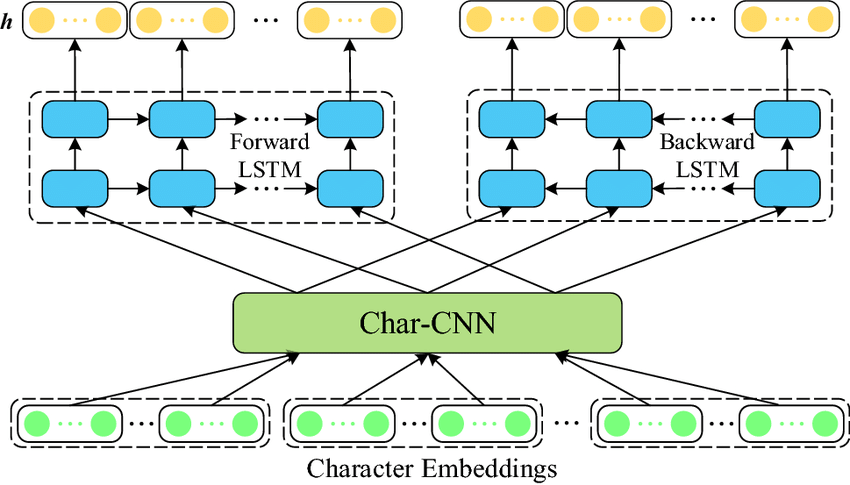

In [112]:
Image(filename='ELMO.png', width=600)

*Image source: https://www.researchgate.net/publication/339312186_From_static_to_dynamic_word_representations_a_survey* 


The pseudo-algorithm for ELMo is as follows:

*input*: a sequence of words $w_1, w_2, ..., w_N$
*ouput*: a sequence of word embeddings $e_1, e_2, ..., e_N$

1. Generate a sequence of character ids $c_1, c_2, ..., c_N$ for each word in the input sequence using a CNN
2. Pass the sequence of character ids through a bidirectional LSTM to generate a sequence of word representations $h_1, h_2, ..., h_N$
3. Generate a sequence of word embeddings $e_1, e_2, ..., e_N$ by concatenating the forward and backward representations of each word in the sequence
4. Return the sequence of word embeddings


**The mathematical understanding of ELMo**

*Bidirectional language model*
Given a sequence of $N$ tokens, $(t_1, t_2, ..., t_N)$, a forward language computes the probability of the sequence by modeling the probability of each token given the previous tokens in the sequence:

$$P(t_1, t_2, ..., t_N) = \prod_{i=1}^N P(t_i | t_1, t_2, ..., t_{i-1})$$

Since ELMo uses a bidirectional language model, it also models the probability of each token given the subsequent tokens in the sequence, which is the backward language model:

$$P(t_1, t_2, ..., t_N) = \prod_{i=1}^N P(t_i | t_{i+1}, t_{i+2}, ..., t_N)$$

The output of the forward and backward language models are then concatenated to generate a single vector for each token:

$$f(t_i) = [f_1(t_i), f_2(t_i), ..., f_d(t_i)]$$

$$b(t_i) = [b_1(t_i), b_2(t_i), ..., b_d(t_i)]$$

where $d$ is the dimension of the word embeddings.

The joint log-likelihood of the forward and backward language models is then computed as:

$$L = \sum_{i=1}^N \log P(t_i | t_1, t_2, ..., t_{i-1}) + \log P(t_i | t_{i+1}, t_{i+2}, ..., t_N)$$

which is then maximised using gradient descent.

At each position $i$, each LSTM layer outputs a context-dependent representation $h_i^L$, where $L$ is a layer in the network, which is then passed through a feed-forward neural network to generate a vector $e_i^L$:

The embedding for each token is then computed as the average of the forward and backward language models:

$$e_i = \frac{1}{2} (f(t_i) + b(t_i))$$

In [12]:
import pandas as pd
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub

tf.disable_eager_execution()
tf.reset_default_graph()

# Load pre-trained ELMo model
elmo_module = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

# Function to get ELMo embeddings for a sentence
def get_elmo_embeddings(sentences):
    """Returns ELMo embeddings for a list of sentences
    
    Args:
        sentences (list): A list of sentences.
    """
    embeddings = elmo_module(
        sentences,
        signature="default",
        as_dict=True)["elmo"]
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)

# Get ELMo embeddings for each sentence in the DataFrame
embeddings = get_elmo_embeddings(df['cleaned'].tolist())


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
print(embeddings.shape)
print(type(embeddings))

(53, 82, 1024)
<class 'numpy.ndarray'>


In [14]:
#the embeddings are 3 dimensional, so we need to reshape them to 2 dimensions
X = embeddings.reshape(embeddings.shape[0], embeddings.shape[1]*embeddings.shape[2])

df_train, df_test = train_test_split(df, test_size=0.1, random_state=35) #splitting the data into train and test

X_train, X_test = train_test_split(X, test_size=0.1, random_state=35)
X_train.shape, X_test.shape

((47, 83968), (6, 83968))

In [20]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

After using ELMo to generate word embeddings, we get an output of (82, 1024) for each row in our data. This is because the ELMo model generates 1024-dimensional word embeddings for each word in the input sequence. The 82 is the number of words in a sentence. 

This is the first change I make to my pipeline. The question I am trying to answer is:

*To what extent can we improve the performance of the clustering model by using a word embedding model?*

I use a K-means clustering algorithm, like I did in the previous assignment.

In [21]:
n = 3
# create and fit KMeans model
kmeans = KMeans(n_clusters=n, random_state=35, init='k-means++')
kmeans.fit(X)

# get cluster labels and silhouette score
clusters = kmeans.labels_
score = silhouette_score(X, clusters)
score

C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.044566408

The silhouette score measures how similar an object is to its own cluster compared to other clusters. The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighbouring clusters.

6.1.2. **Hyperparameter tuning**

In [22]:
n = [3, 4, 5]
models = {}

for i in n:
    model = KMeans(n_clusters=i, random_state=35, init='k-means++')
    model.fit(X_train)
    labels = model.labels_
    score = silhouette_score(X_train, labels)
    models[i] = (labels, score)
models

C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less 

{3: (array([1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2,
         1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]),
  0.027414845),
 4: (array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1]),
  0.18930377),
 5: (array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 2]),
  0.042517755)}

The best number of cluster is 4 based on the silhouette score. It has a score of 0.189, which is significantly higher than the best score of the previous model where I used TF-IDF vectors. The best score for the previous model was 0.0659. That is an approximately 2.9x improvement. 

6.1.3. **Prediction**

In [49]:
model = KMeans(n_clusters=4, random_state=35, init='k-means++') #using the best number of clusters
model.fit(X_train)

labels = model.labels_
df_train['cluster'] = labels
df_train.head()

C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,poetry,cleaned,cluster
48,Knowledge is poisonous for those who do not know how to handle it. Not everyone knows how to swi...,knowledge poisonous know handle everyone knows swing double edged blade hold fragility ticking t...,0
32,To the boy who never broke Only bent into jagged pieces one by one. You have stood with tremblin...,boy never broke bent jagged pieces one one stood trembling rage long long limbed fingers sharp e...,0
20,But it feels like the slow burning of jumping into a frozen lake instead. It is ice and frost an...,feels like slow burning jumping frozen lake instead ice frost winter nights brutal sky bed snow ...,0
51,There are empty corridors where the first rays of sunlight flitter through like muffled laughter...,empty corridors first rays sunlight flitter like muffled laughter shy glances promised battlefie...,0
38,"Tell me how your hands beg to touch cold waters, and soft palms and the rightness of a lover bes...",tell hands beg touch cold waters soft palms rightness lover beside every one 27 bones hand aches...,0


In [51]:
predictions = model.predict(X_test)
df_test['cluster'] = predictions
df_test.head()

predictions

array([0, 0, 0, 0, 0, 0])

The model seems to be biased towards the first cluster. The high silhouette score for this model is probably because of this bias then. Maybe using a clustering algorithm is not the best approach then. 

Approach 2 and 3 explore other ways to extract useful information about the data

---------------------

**For the next two approaches, I will be using the whole data, labelled X, instead of the training data, X_train. This is because the goal for the other two approaches is to extract useful information, not predict the labels.*

6.2 *Approach 2: Topic Modeling*

In this approach, I continue using ELMo embedding but instead of clustering the data using K-means, I use topic modeling to find the topics in the data.

Topic modeling is a method for discovering the abstract "topics" that occur in a collection of documents or text. It is a form of unsupervised machine learning, which means that the model is not trained on labeled data. Instead, it learns the topics from the data itself. 



6.2.1. **Model description**

##### Latent Dirichlet Allocation (LDA)

LDA is a generative probabilistic model that assumes that each document is a mixture of topics, and each topic is a mixture of words. The model is trained on a corpus of documents, and it learns the topics and the probability of each word in the vocabulary belonging to each topic.

- Each topic is a distribution over words
- Each document is a mixture of corpus-wide topics
- Each word is drawn from one of these topics
- We only observe the words in the document and other structure are **hidden variables**.

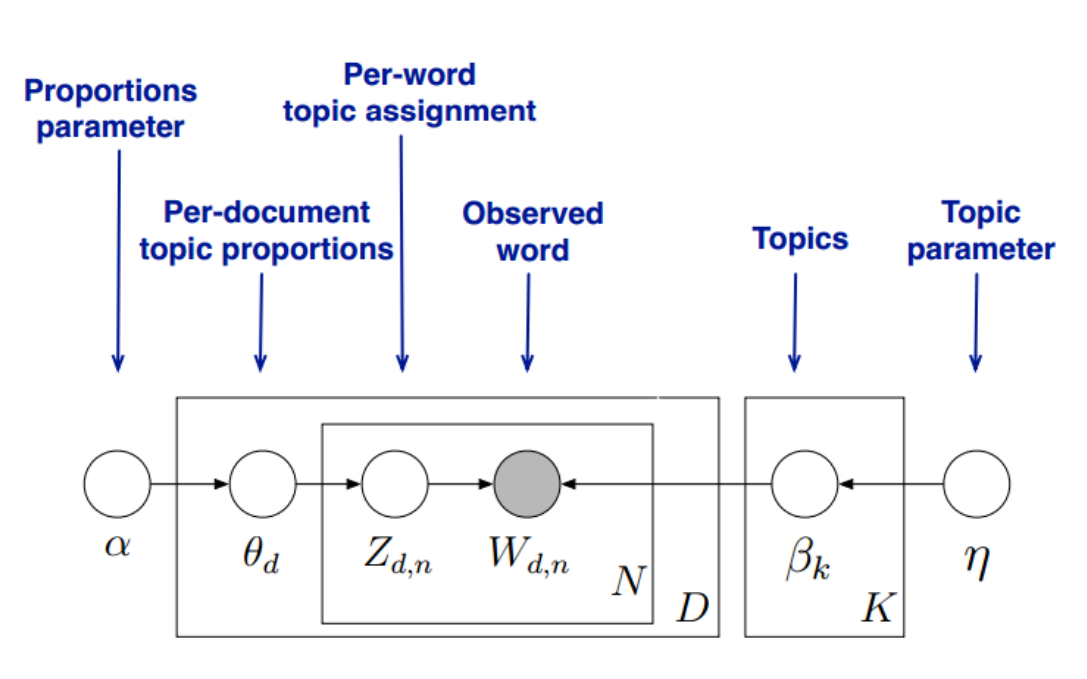

In [113]:
Image(filename='LDA.png', width=600)

**The image is taken from: https://redirect.cs.umbc.edu/courses/undergraduate/478/spring2018/LDA.pdf* 

In the above graph of LDA, the nodes are random variables and the edges are conditional dependencies. The shades nodes are observed variables, and the unshaded nodes are hidden variables. The boxes indicate replicated variables. 

The algorithm is as follows:
1. Initialize the topics randomly
2. For each topic $\beta_i \sim Dir(\eta)$ for $i = 1, ..., K$
3. For each document $\theta_d \sim Dir(\alpha)$ for $d = 1, ..., D$
4. For each word in the document:
<br>
    a. Sample the topic $z_{d,n} \sim Multi(\theta_d)$
<br>
    b. Sample the word $w_{d,n} \sim Multi(\theta_d, \beta_{z_{d,n}})$ for $n = 1, ..., N_d$

The goal of the algorithm is to estimate the hidden variables, i.e., computing their posterior distribution:

$$P(z, \theta, \beta | w)$$

1. Per-word topic assignment $z_{d,n}$
2. Topic distribution for each document $\theta_d$
3. Word distribution for each topic $\beta_i$


$$P(z, \theta, \phi | w, \alpha, \beta)$$

where $z$ is the topic of each word in the document, $\theta$ is the topic distribution of each document, $\phi$ is the word distribution of each topic, $w$ is the vocabulary, $\alpha$ is the topic prior, and $\beta$ is the word prior.

The model is hence defined as:

$$ p(w, z, \theta, \beta) = \left (\prod_{i=1}^K p(\beta_i | \eta) \right)  \left (\prod_{d=1}^D  p(\theta_d | \alpha) \prod_{n=1}^{N}  p(z_{d,n} | \theta_d)  p(w_{d,n} | \beta_{1:K}, z_{d,n}) \right)$$

where $K$ is the number of topics, $D$ is the number of documents, $N$ is the number of words in the document, and $w$ is the vocabulary.

- $(\beta_d | \eta) \sim Dir(\beta)$
- $(\theta_d | \alpha) \sim Dir(\alpha)$
- $Z_{d,n} \sim Mult(\theta_d)$
- $W_{d,n} \sim Multi(\beta_{z_{d,n}})$
- $ p(z_{d, n} | \theta_d) = \theta_{d, z_{d, n}}$
- $ p(w_{d, n} | \beta_{1:K}, z_{d, n}) = \beta_{z_{d, n}, w_{d, n}}$

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the Elmo embeddings using min-max scaling
scaler = MinMaxScaler()
normalized_embeddings = scaler.fit_transform(X)

# Topic modeling using LDA on the Elmo embeddings
lda = LatentDirichletAllocation(n_components=10, max_iter=50, learning_method='online', random_state=0)
lda.fit(normalized_embeddings)



LatentDirichletAllocation(learning_method='online', max_iter=50, random_state=0)

We had to scale the embeddings to only contain positive values since the Dirichlet distribution only takes positive values.

6.2.2. **Topic distributions**

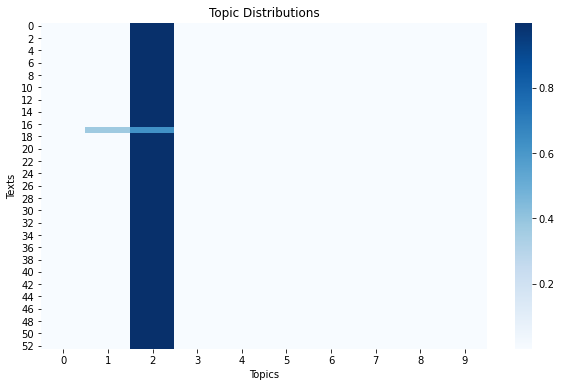

In [91]:
import seaborn as sns

#predicting the clusters
topic_distributions = lda.transform(normalized_embeddings)
topic_distributions.shape

#topics and their distribution
topic_distributions[0]

#plotting a headmap of the topics
plt.figure(figsize=(10, 6))
sns.heatmap(topic_distributions, cmap='Blues')
plt.title('Topic Distributions')
plt.xlabel('Topics')
plt.ylabel('Texts')
plt.show()


The heatmap over the topics shows that the topics are not well separated. This might be because the data is not well clustered, but requires further exploration to be sure. In the plot, we can see that topic 2 is present in all the texts with a high probability. Other topics are not present at all in all the texts. We can plot them as clusters as well to see if they are well separated.

In [92]:
lda.components_.shape
topic_distributions.shape

(53, 10)

[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 53 samples in 0.000s...
[t-SNE] Computed neighbors for 53 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 53 / 53
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.558006
[t-SNE] KL divergence after 300 iterations: 0.018472


C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


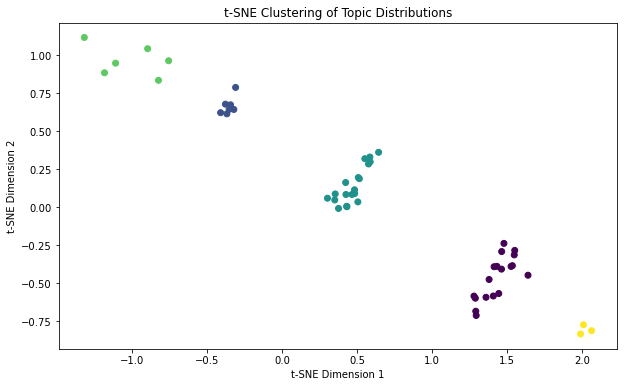

In [78]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use t-SNE to reduce the dimensionality of the topic distributions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(topic_distributions)

# Use K-means clustering to cluster the data
kmeans = KMeans(n_clusters=5, random_state=35).fit(tsne_results)

# Visualize the results using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_)
plt.title('t-SNE Clustering of Topic Distributions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In the above scatter plot topic distributions, which are the probability of each word belonging to each topic, are plotted as clusters. The topic distributions were previously (53, 10). I use t-SNE to reduce the dimensionality of the data to 2.

t-SNE is a dimensionality reduction technique that is commonly used in NLP. It is a stochastic neighbor embedding technique that is particularly well suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.

After the dimensionality reduction, we can see that the topics are well separated. I tried using different number of clusters and found that 5 gave the best results. 

---------------------------

6.3. *Approach 3: Topic modeling with feature extraction using Autoencoders*

Feature extraction is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

6.3.1. **Model description**

##### Autoencoders

Autoencoders are a type of neural network that are used for unsupervised learning. They are used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal "noise".

They follow the following algorithm:
1. Initialize the hyperparameters including the number of layers, the number of neurons in each layer, the activation function, the loss function, the optimizer, etc.
2. Define the encoder architecture by creating a sequential model and adding the layers. Each layer uses the activation function specified in the hyperparameters.
3. Define the decoder architecture by creating another sequential neural network with the same number of layers and nodes as the encoder, but in reverse order. Use the same activation functions for each layer.
4. Define the autoencoder by creating a sequential model and adding the encoder and decoder.
5. Compile the autoencoder using the loss function and optimizer specified in the hyperparameters.
6. Train the autoencoder on the training data, specifying the number of epochs, the batch size, learning rate etc.
7. Use the trained encoder weights to transform the input data into compressed latent space representation.

The following image shows the architecture of an autoencoder:

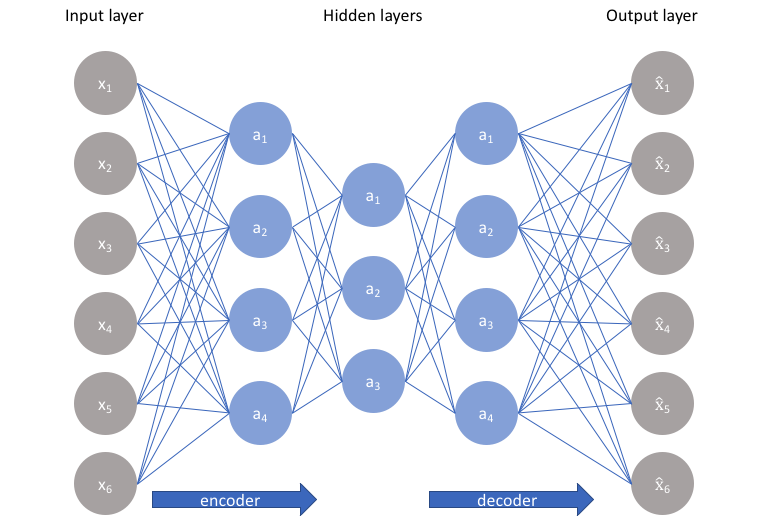

In [115]:
Image(filename='autoencoder.png', width=500)


In this approach, I will be using the word embeddings, but I will first pass it through an autoencoder to extract salient features. The LDA model is then trained on the features instead of the word embeddings.

In [79]:

# Autoencoder
input_dim = X.shape[1]
encoding_dim = 100
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)
autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X, X, epochs=50, batch_size=32)

# Use encoder to extract features
encoder = Model(inputs=input_layer, outputs=encoder_layer)
features = encoder.predict(X)


Train on 53 samples
Epoch 1/50
53/53 [==============================] - 1s 23ms/sample - loss: 0.6915
Epoch 2/50
53/53 [==============================] - 0s 4ms/sample - loss: 0.5518
Epoch 3/50
53/53 [==============================] - 0s 3ms/sample - loss: 0.1364
Epoch 4/50
53/53 [==============================] - 0s 5ms/sample - loss: -0.1128
Epoch 5/50
53/53 [==============================] - 0s 5ms/sample - loss: -0.3537
Epoch 6/50
53/53 [==============================] - 0s 4ms/sample - loss: -0.7177
Epoch 7/50
53/53 [==============================] - 0s 4ms/sample - loss: -1.2679
Epoch 8/50
53/53 [==============================] - 0s 3ms/sample - loss: -1.9046
Epoch 9/50
53/53 [==============================] - 0s 3ms/sample - loss: -2.7492
Epoch 10/50
53/53 [==============================] - 0s 3ms/sample - loss: -3.7790
Epoch 11/50
53/53 [==============================] - 0s 3ms/sample - loss: -4.9664
Epoch 12/50
53/53 [==============================] - 0s 3ms/sample - loss: -6.

C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [94]:
# Calculate the reconstruction error
mse = autoencoder.evaluate(X, X)
print(f'Reconstruction error: {mse}')

C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Reconstruction error: -293.70577830188677


In [81]:
lda_featured = LatentDirichletAllocation(n_components=10, max_iter=50, learning_method='online', random_state=0)
lda_featured.fit(features)

topic_distributions_featured = lda_featured.transform(features)


6.3.2. **Topic distributions and features**

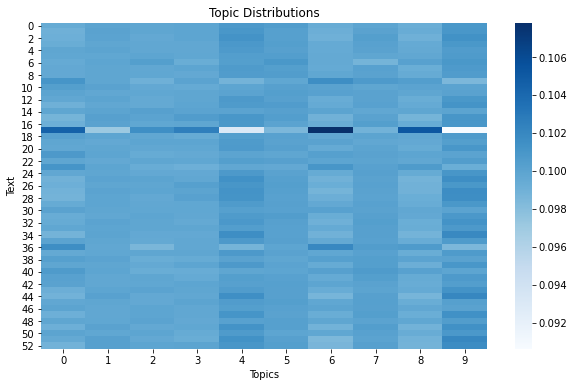

In [83]:
import seaborn as sns

#plotting a headmap of the topics
plt.figure(figsize=(10, 6))
sns.heatmap(topic_distributions_featured, cmap='Blues')
plt.title('Topic Distributions')
plt.xlabel('Topics')
plt.ylabel('Text')
plt.show()

This heatmap looks much better than the previous one. The topics are somewhat distributed evenly across the texts. Unlike the previous heatmap, topic 2 isn't preferred over all others. Text 17 seems to be an outlier though, it has a high probability of topic 0, 6 and 8 but zero probability of topic 4 and 9. This is different than other texts that all show a small to moderate probability of all topics.

Ideally we would want a heatmap where all texts have a distribution similar to text 17, with more definite probabilities rather than an almost random guess. However, this is a better topic distribution compared to running an LDA with just word embeddings. This is perhaps because the word embeddings are very high dimensional and have so much information, most of which might be useless. Autoencoders are able to extract the most important features from the word embeddings and use them to train the LDA model.

[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 53 samples in 0.000s...
[t-SNE] Computed neighbors for 53 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 53 / 53
[t-SNE] Mean sigma: 0.001485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.510563
[t-SNE] KL divergence after 300 iterations: 0.008139


C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saai2\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


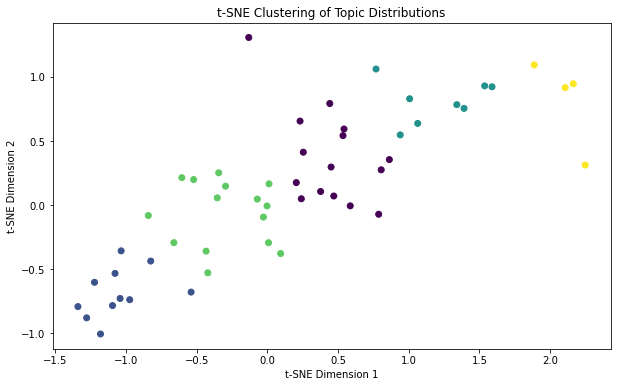

In [103]:
# Use t-SNE to reduce the dimensionality of the topic distributions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(topic_distributions_featured)

# Use K-means clustering to cluster the data
kmeans = KMeans(n_clusters=5, random_state=35).fit(tsne_results)

# Visualize the results using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_)
plt.title('t-SNE Clustering of Topic Distributions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

The scatter plot of the topic distributions shows that the topics are well separated. They are not as well separated as the previous scatter plot, but they still show distinct clusters. The axes of the two scatter plots are also different, however not by too much. This does reflect the differences in the topic distributions though.

While in the previous model, increasing the number of kmeans clusters showed better clustered topics, in this model, increasing the number of clusters did not show better results. On average, changing the number of clusters did not change how spread out the clusters were.

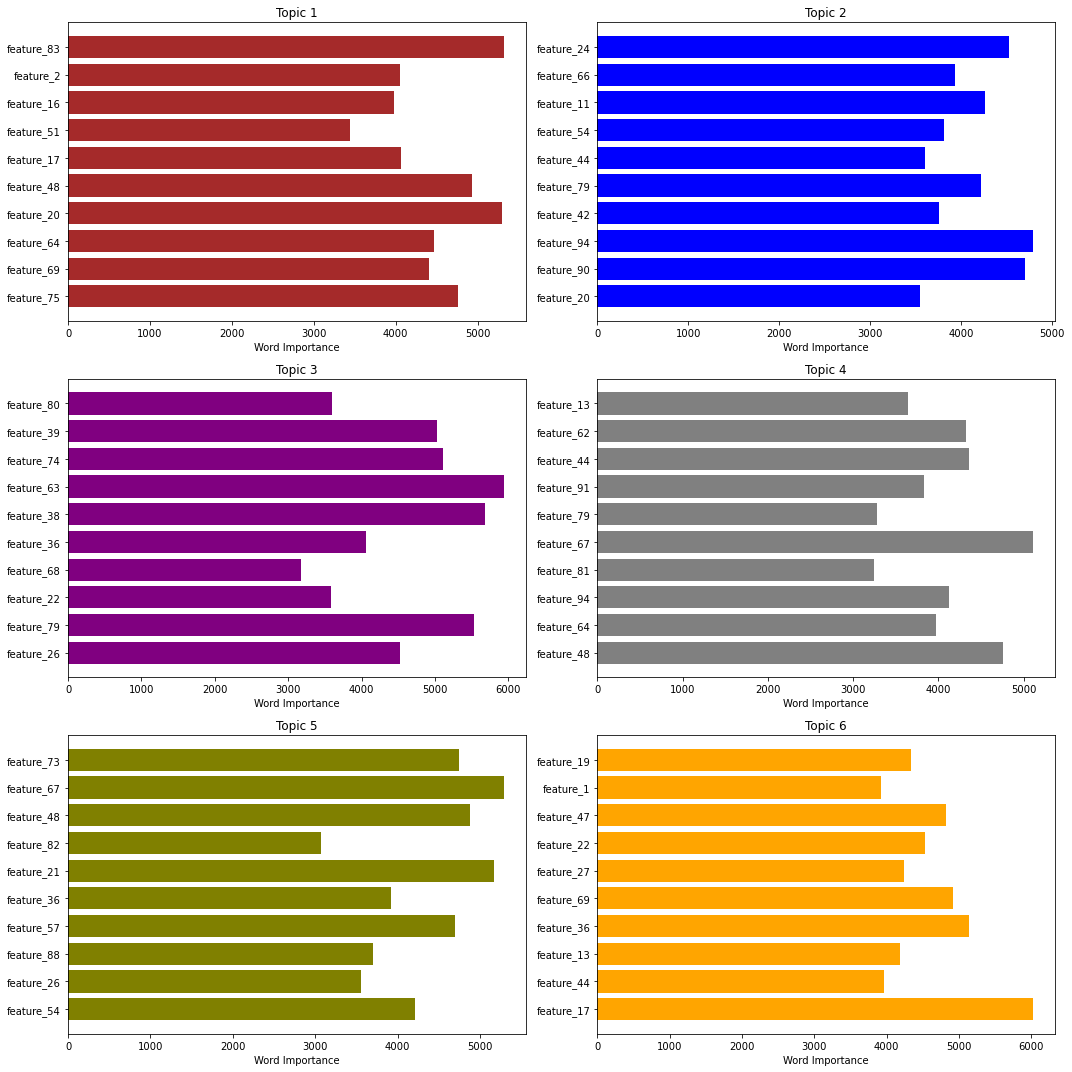

In [105]:
# Extract feature names from the encoder layer
feature_names = [f'feature_{i}' for i in range(encoding_dim)]

# Extract the top 10 words for each topic
n_top_words = 10
topic_top_words = {}
for topic_idx, topic in enumerate(lda_featured.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    topic_top_words[topic_idx] = [feature_names[i] for i in top_words_idx]

colors = ['brown', 'blue', 'purple', 'gray', 'olive', 'orange']

# Plot the top words for each topic in a 3x2 subplot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for ax, topic_idx in zip(axes.flatten(), range(6)):
    top_words = topic_top_words[topic_idx]
    ax.barh(np.arange(n_top_words), lda_featured.components_[topic_idx][top_words_idx], align='center', color=colors[topic_idx], ecolor='black')
    ax.set_yticks(np.arange(n_top_words))
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()
    ax.set_xlabel('Word Importance')
    ax.set_title(f'Topic {topic_idx + 1}')
plt.tight_layout()
plt.show()



The above plot shows the distribution of features in the first 6 topics. There are a total of 100 features extracted from the autoencoder and this plot shows the importance of the top 10 features in each topic.

This can help up understand what each topic is about. The importance of a feature in a given topic dictates the content of that topic and is hence a good reflection of the cluster it belongs to. 

------------------------------------------

#### **7. Conclusion**

In this project, I explored the use of three different approaches:
1. Clustering with word embeddings 
2. Topic modeling with word embeddings
3. Topic modeling with feature extraction using autoencoders

Each layer of complexity added to the model improved the results in some way. However, as the complexity increase, the model becomes less interpretable. While introducing a different vectorization technique might improved the clustering results, the model still performed poorly in labelling the texts. 

Using topic modeling with word embeddings allowed me to extract more useful information from the texts. However, topic modeling performed much better with feature extraction using autoencoders. The topic distributions were more evenly distributed across the texts and the topics were well separated. The topics were also more interpretable.


------------------------------

#### **8. Use of AI tools**

I used ChatGPT to debug my code as Natural-Language Processing requires a lot of understanding as to what the code is doing. I also used ChatGPT for explaining the more complex models in my assignment so that I could understand them better. I was also able to ask follow up questions so that I could convey the information in an efficient & intutitive manner. Finally, I wasn't sure how to visualize the topic distributions from my LDA model. I refered to ChatGPT to understand how to do this.

------------------

#### **9. Data Ethics**

All of the data that I used in this assignment doesn't mention any individuals so can't be linked or associated with someone. Moreover, since the data is not taken from any external source, data privacy is maintained & is not a concern. The data is also not sensitive in nature so there is no risk of data being misused.  
I have tried to be explicit and transparent about all the ways that I have processed the data in this assignment so that any reader can be sure that the data was not manipulated in any way for any other purpose. Furthermore, I have also tried not to let any bias creep into the data by being as objective as possible with all the algorithms that I have used.  
Finally, my pipeline works to extract the most important information from my writing which could have a positive impact on people who write as it could help them understand patterns in their writing better. A negative social impact of this pipeline does not seem a risk to me at this stage.

------------------------------------------

#### **10. References**

Wang, Yuxuan & Hou, Yutai & Che, Wanxiang & Liu, Ting. (2020). From static to dynamic word representations: a survey. *International Journal of Machine Learning and Cybernetics. 11*. 10.1007/s13042-020-01069-8. 

Peters, M. E., Neumann, M., Iyyer, M., Gardner, M., Clark, C., Lee, K., & Zettlemoyer, L. (2018). Deep contextualized word representations. *ArXiv*. /abs/1802.05365

Open, A. I. (2023). Chat.openai.com. ChatGPT. Retrieved March 31, 2023, from https://chat.openai.com/ 

Amir, S. A. (2023). Sentiment analysis of poetry pieces using Kmeans clustering algorithm. GitHub. Retrieved April 1, 2023, from https://github.com/s-abeera/Sentiment-Analysis-

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

https://redirect.cs.umbc.edu/courses/undergraduate/478/spring2018/LDA.pdf

